In [1]:
import pyspark
from random import randint, random, choice
import matplotlib.pyplot as plt

sc = pyspark.SparkContext('local[*]')

In [2]:
from dataGenerator.rowGenerator import *
from dataGenerator.datasetGenerator import *
from datetime import datetime

dataset = datasetGenerator()
dataset.addGenerator(randomFromListGenerator(),list=['P&P103','P&P104','P&P105'],keyName="machineId")
dataset.addGenerator(intGenerator(),min=1,max=5000,keyName="itemId")
dataset.addGenerator(intGenerator(),min=1,max=10,keyName="errors")
dataset.addGenerator(dateGenerator(),min=1,max=10,keyName="ts")
dataset.addGenerator(randomFromListGenerator(),list=['In Progress', 'Idle','Done'],keyName="status")

rdd = sc.parallelize(dataset.generateDataset(10000)).persist()

In [3]:
rdd.take(5)

[{'machineId': 'P&P104',
  'itemId': 1458,
  'errors': 4,
  'ts': datetime.datetime(2011, 4, 23, 7, 52, 7),
  'status': 'In Progress'},
 {'machineId': 'P&P105',
  'itemId': 2981,
  'errors': 5,
  'ts': datetime.datetime(2014, 10, 10, 21, 12, 14),
  'status': 'Done'},
 {'machineId': 'P&P104',
  'itemId': 1016,
  'errors': 2,
  'ts': datetime.datetime(2013, 7, 19, 20, 41, 25),
  'status': 'Idle'},
 {'machineId': 'P&P105',
  'itemId': 4515,
  'errors': 2,
  'ts': datetime.datetime(2020, 5, 27, 22, 28, 33),
  'status': 'Idle'},
 {'machineId': 'P&P104',
  'itemId': 4496,
  'errors': 8,
  'ts': datetime.datetime(2017, 7, 1, 2, 57, 54),
  'status': 'In Progress'}]

In [4]:
notdone = rdd.filter(lambda x: x.get('status') != 'Done')
notdone.take(5)

[{'machineId': 'P&P104',
  'itemId': 1458,
  'errors': 4,
  'ts': datetime.datetime(2011, 4, 23, 7, 52, 7),
  'status': 'In Progress'},
 {'machineId': 'P&P104',
  'itemId': 1016,
  'errors': 2,
  'ts': datetime.datetime(2013, 7, 19, 20, 41, 25),
  'status': 'Idle'},
 {'machineId': 'P&P105',
  'itemId': 4515,
  'errors': 2,
  'ts': datetime.datetime(2020, 5, 27, 22, 28, 33),
  'status': 'Idle'},
 {'machineId': 'P&P104',
  'itemId': 4496,
  'errors': 8,
  'ts': datetime.datetime(2017, 7, 1, 2, 57, 54),
  'status': 'In Progress'},
 {'machineId': 'P&P103',
  'itemId': 2732,
  'errors': 7,
  'ts': datetime.datetime(2013, 11, 16, 20, 5, 43),
  'status': 'Idle'}]

In [5]:
errpermachine = notdone.map(lambda x: (x.get('machineId'), x.get('errors'))).reduceByKey(lambda a,b: a+b)
errpermachine.collect()

[('P&P103', 11907), ('P&P105', 12247), ('P&P104', 12502)]

<BarContainer object of 3 artists>

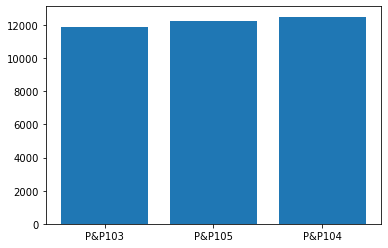

In [6]:
plt.bar(errpermachine.map(lambda x: x[0]).collect(), errpermachine.map(lambda x: x[1]).collect())

In [7]:
errpermonth = notdone.map(lambda x: (x.get('ts').month, x.get('errors'))).reduceByKey(lambda a,b: a+b)
errpermonth.collect()

[(8, 2865),
 (9, 3139),
 (1, 3332),
 (2, 2722),
 (10, 3325),
 (11, 2978),
 (3, 3136),
 (4, 3267),
 (12, 2974),
 (5, 2932),
 (6, 2971),
 (7, 3015)]

<BarContainer object of 12 artists>

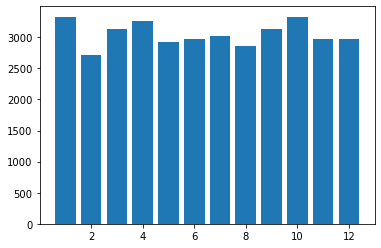

In [8]:
plt.bar(errpermonth.map(lambda x: x[0]).collect(), errpermonth.map(lambda x: x[1]).collect())

In [9]:
perper = notdone.map(lambda x: ((x.get('machineId'), x.get('ts').month), x.get('errors'))).reduceByKey(lambda a,b: a+b).sortBy(lambda x: x[0][1])
perper.collect()

[(('P&P103', 1), 1150),
 (('P&P104', 1), 1039),
 (('P&P105', 1), 1143),
 (('P&P104', 2), 898),
 (('P&P103', 2), 860),
 (('P&P105', 2), 964),
 (('P&P103', 3), 960),
 (('P&P105', 3), 1128),
 (('P&P104', 3), 1048),
 (('P&P104', 4), 1148),
 (('P&P105', 4), 1083),
 (('P&P103', 4), 1036),
 (('P&P104', 5), 909),
 (('P&P105', 5), 973),
 (('P&P103', 5), 1050),
 (('P&P103', 6), 955),
 (('P&P105', 6), 942),
 (('P&P104', 6), 1074),
 (('P&P105', 7), 1113),
 (('P&P104', 7), 974),
 (('P&P103', 7), 928),
 (('P&P105', 8), 906),
 (('P&P103', 8), 910),
 (('P&P104', 8), 1049),
 (('P&P103', 9), 939),
 (('P&P104', 9), 1135),
 (('P&P105', 9), 1065),
 (('P&P104', 10), 1223),
 (('P&P103', 10), 1099),
 (('P&P105', 10), 1003),
 (('P&P103', 11), 948),
 (('P&P105', 11), 1053),
 (('P&P104', 11), 977),
 (('P&P104', 12), 1028),
 (('P&P105', 12), 874),
 (('P&P103', 12), 1072)]

<BarContainer object of 36 artists>

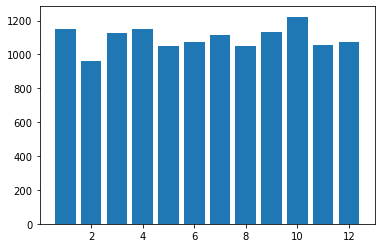

In [10]:
plt.bar(perper.map(lambda x: x[0][1]).collect(), perper.map(lambda x: x[1]).collect()) # not quite correct